# [IAPR 2020:][iapr2020] Lab 1 ‒  Image segmentation

**Author:** first name and last name  
**Due date:** 26.03.2020

[iapr2018]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [342]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

In [343]:
# imports
import numpy as np;

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

Text(0.5, 1.0, 'MRI brain image (256 px, 256 px)')

(-0.5, 255.5, 255.5, -0.5)

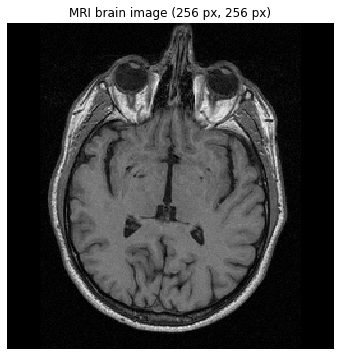

In [344]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing
Add your implementation and discussion

In [221]:
import cv2
import numpy as np

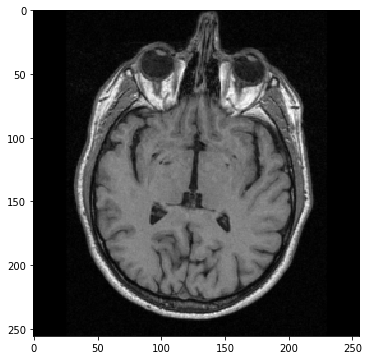

In [222]:
# Using Gaussian filter to denoise image
brain_denoise = cv2.GaussianBlur(brain_im,(5,5),0.5,0.5)
plt.figure(figsize=[6,6])
plt.imshow(brain_denoise,cmap='gray')

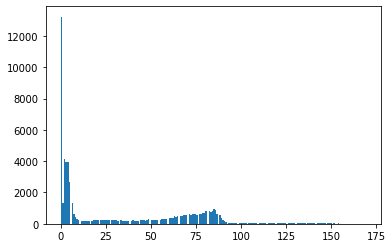

In [223]:
plt.hist(brain_denoise.ravel(),bins=200)
plt.show()

In [224]:
def region_growing(img, seed, threshold):

    img = np.float32(img)
    
    # 8-connected growing method
    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1),(-1,-1),(-1,1),(1,1),(1,-1)]
    region_size = 1
    neighbor_points_list = []
    neighbor_points_list.append(seed)
    
    #Initialize segmented output image
    height,width = img.shape
    segmented_img = np.zeros((height, width), np.uint8)
    
    while len(neighbor_points_list) != 0:  
        
        seed = neighbor_points_list.pop(0)
        for i in range(8):
            
            #Compute the neighbor pixel position
            x_new = seed[0] + neighbors[i][0]
            y_new = seed[1] + neighbors[i][1]
            
            checkout = (x_new >= 0) & (y_new >= 0) & (x_new < height) & (y_new < width)
            if checkout:
                if segmented_img[x_new, y_new] == 0:
                    
                    # compute difference
                    difference = np.abs(img[x_new,y_new]-img[seed[0],seed[1]])
                    
                    if difference <= threshold:
                        
                        neighbor_points_list.append([x_new,y_new])
                        segmented_img[x_new, y_new] = 255
                        region_size+=1
                        
    return segmented_img,region_size

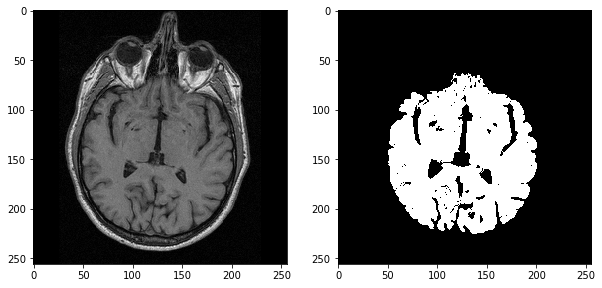

In [225]:
# set seed
seed = [153,82]
segmented_img, region_size = region_growing(brain_denoise, seed, 4)
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(brain_im, cmap='gray')
ax[1].imshow(segmented_img,cmap='gray')
plt.show()

In [226]:
print("The brain size is ",region_size)

The brain size is  16117


In [227]:
# try to combine the two thresholding parameters to get better result

##### 1.3 Contour detection
Add your implementation and discussion

### Canny edge detection (multi-stage algorithm)

In [228]:
from scipy import ndimage

# # riscrivere la funzione!!
# def gaussian_kernel(size, sigma=1):
#     size = int(size) // 2
#     x, y = np.mgrid[-size:size+1, -size:size+1]
#     normal = 1 / (2.0 * np.pi * sigma**2)
#     g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
#     return g

# image_denoised = ndimage.convolve(brain_im, gaussian_kernel(5), mode='constant', cval=0.0)
# plt.imshow(image_denoised, cmap='gray')
# plt.show()

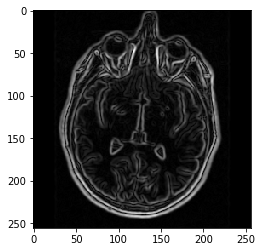

In [15]:
# # show gradients code
# import scipy
# from scipy import ndimage

# image_denoised = image_denoised.astype('int32')
# dx = ndimage.sobel(image_denoised, 0)  # horizontal derivative
# dy = ndimage.sobel(image_denoised, 1)  # vertical derivative
# image_gradients = np.hypot(dx, dy)  # magnitude
# image_gradients *= 255.0 / np.max(image_gradients)  # normalize (Q&D)
# plt.imshow(image_gradients, cmap='gray')
# plt.show()

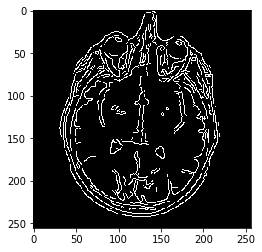

In [229]:
# Canny algorithm
# 1) Noise reduction
# 2) Gradient calculation
# 3) Non-maximum suppression
# 4) Double threshold
# 5) Edge Tracking by Hysteresis

from skimage import feature

edges = skimage.feature.canny(
    image=brain_im,
    sigma=.8,
    low_threshold=55,
    high_threshold=90,
)

# display edges
plt.imshow(edges, cmap='gray')
plt.show()

In [205]:
type(edges)
edges

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

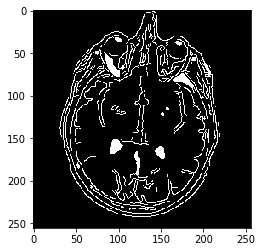

In [209]:
from scipy import ndimage as ndi
fill_brain = ndi.binary_fill_holes(edges)

plt.imshow(fill_brain, cmap='gray')
plt.show()

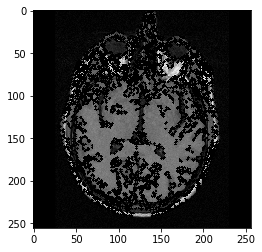

In [291]:
import cv2
i = brain_im.copy()
mask = cv2.Canny(i, 55, 90)
cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for c in cnts[0]:
    c = cv2.convexHull(c)
    
for c in cnts[0]:
    cv2.drawContours(i, c, -1, (0, 230, 255), 2)
    
plt.figure()
plt.imshow(i, cmap='gray')

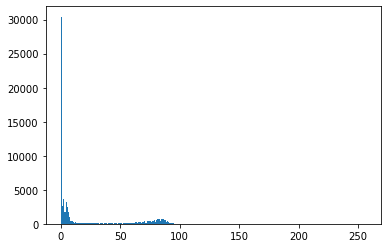

In [303]:
plt.hist(i.ravel(), 256,[0,256])
plt.show()

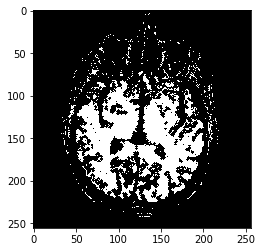

In [311]:
# copy the function threshold above it (you find it below)
i_thresholded = threshold(65, 95, i)
plt.figure()
plt.imshow(i_thresholded, cmap='gray')

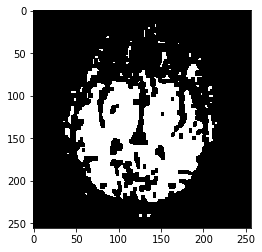

In [377]:
kernel1 = np.ones((2,2), np.uint8) 
kernel2 = np.ones((2,1), np.uint8) 
kernel3 = np.ones((2,2), np.uint8) 


# The first parameter is the original image, 
# kernel is the matrix with which image is  
# convolved and third parameter is the number  
# of iterations, which will determine how much  
# you want to erode/dilate a given image.  
# img_erosion = cv2.erode(i_thresholded, kernel, iterations=1) 
# img_dilation = cv2.dilate(img_erosion, kernel, iterations=1) 

from scipy import ndimage
img_closing = ndimage.binary_closing(i_thresholded, kernel1, iterations=3) 
img_opening = ndimage.binary_opening(img_closing, kernel3, iterations=1) 
img_erosion = ndimage.binary_erosion(img_opening, kernel2, iterations=1) 
    
plt.figure()
plt.imshow(img_erosion, cmap='gray')

In [331]:
type(img_closing)

numpy.ndarray

In [187]:
# Active Contour segmentation (snakes)
# snake does not work
#rewrite code

def image_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 14))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

def circle_points(resolution, center, radius):
    """
    Generate points which define a circle on an image.Centre refers to the centre of the circle
    """   
    radians = np.linspace(0, 2*np.pi, resolution)
    c = center[1] + radius*np.cos(radians)#polar co-ordinates
    r = center[0] + radius*np.sin(radians)
    
    return np.array([c, r]).T
# Exclude last point because a closed path should not have duplicate points
points = circle_points(200, [153, 123], 70)[:-1]
# fig, ax = image_show(brain_denoise)
# ax.plot(points[:, 0], points[:, 1], '--r', lw=3)


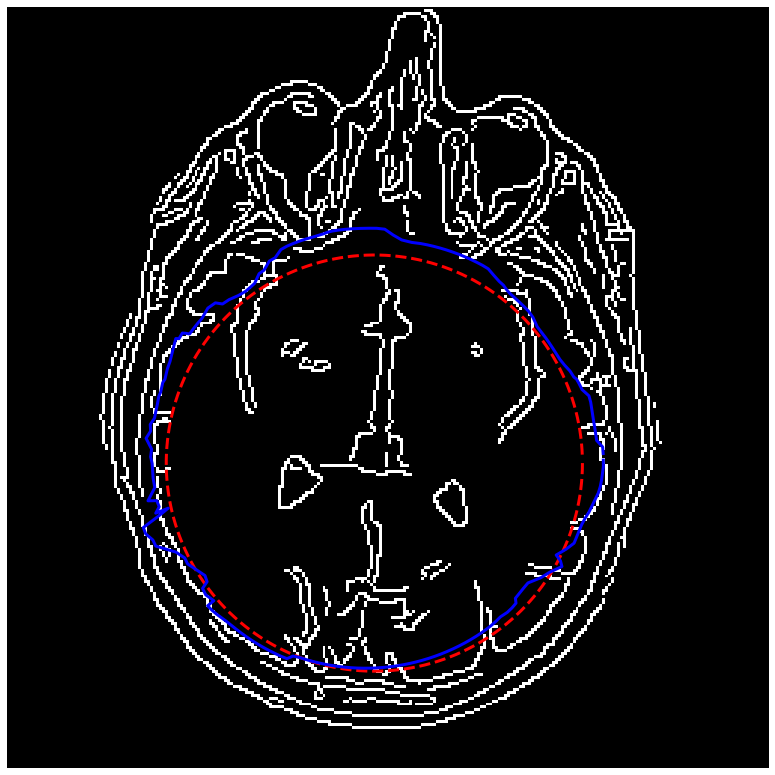

In [188]:
# snake = skimage.segmentation.active_contour(brain_denoise, points, alpha=0.002, beta=1, gamma=0.001)
snake = skimage.segmentation.active_contour(edges, points, alpha=0.015, beta=10, gamma=0.001)

fig, ax = image_show(edges)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3);

# todo detect params alpha, beta, gamma

### 1.4 Additional method(s)
Add your implementation and discussion

(array([1.4407e+04, 2.7140e+03, 3.7290e+03, 1.8140e+03, 3.2950e+03,
        2.5240e+03, 1.7840e+03, 1.0690e+03, 4.3500e+02, 5.7300e+02,
        3.4100e+02, 1.7700e+02, 3.2200e+02, 2.4200e+02, 2.2500e+02,
        9.6000e+01, 2.2400e+02, 2.1200e+02, 2.2500e+02, 2.3900e+02,
        1.2700e+02, 2.4200e+02, 2.6900e+02, 1.2900e+02, 2.4600e+02,
        2.7500e+02, 2.7200e+02, 1.2800e+02, 2.5200e+02, 2.3900e+02,
        2.2200e+02, 2.1200e+02, 1.1700e+02, 2.0800e+02, 2.3300e+02,
        9.3000e+01, 2.2500e+02, 2.4300e+02, 2.2400e+02, 1.0500e+02,
        2.1100e+02, 2.1700e+02, 2.0600e+02, 2.2500e+02, 1.1500e+02,
        2.3100e+02, 2.4700e+02, 1.1600e+02, 2.5900e+02, 2.9300e+02,
        2.6100e+02, 1.4900e+02, 2.7800e+02, 2.8200e+02, 3.3200e+02,
        3.4700e+02, 1.7900e+02, 3.2500e+02, 3.5800e+02, 1.8600e+02,
        3.5300e+02, 3.9900e+02, 4.7400e+02, 4.7300e+02, 2.4800e+02,
        5.2100e+02, 5.5100e+02, 3.0000e+02, 6.2900e+02, 6.6300e+02,
        6.6300e+02, 3.1400e+02, 6.8200e+02, 6.97

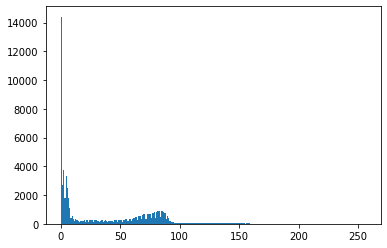

In [347]:
# Histogram
plt.hist(brain_im.ravel(), 256,[0,256]);
plt.show()

# Threshold
def threshold(t1, t2, img):
    th_img = img.copy()
    th_img[th_img < t1] = 0
    th_img[th_img > t2] = 0
    th_img[(th_img >= t1) & (th_img <= t2)] = 1
    return th_img

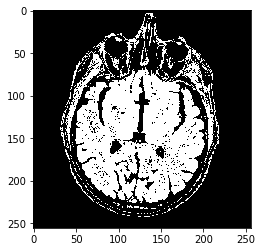

In [348]:
# apply threshold
th_img_wdg = threshold(55, 90, brain_im)
plt.imshow(th_img_wdg, cmap='gray')
plt.show()

# Adaptive thresholding does not make sense since we will have the same intensities in all the image (e.g. no more exposition in a part of the image)

## Thresholding, morphological operators, labeling

<Figure size 432x288 with 0 Axes>

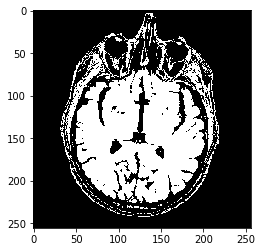

In [349]:
# initial threshold
i_thresholded = threshold(55, 100, i)
# morphological operator kernel
kernel = np.ones((3,3), np.uint8) 
# erosion to separate brain from skull
img_erosion = ndimage.binary_erosion(i_thresholded, kernel, iterations=1) 
plt.figure()
plt.imshow(i_thresholded, cmap='gray')



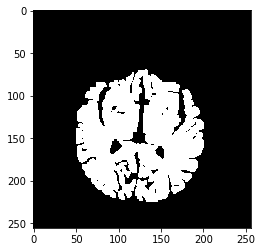

In [350]:
from scipy.stats import mode
# label features
labeled_array, num_features = ndi.label(img_erosion)
# find brain region = largest connected components
brain_region_label,_ = mode(labeled_array[labeled_array!=0])
# isolate brain region
brain_region = np.where(labeled_array == brain_region_label.item(), img_erosion, 0)
# dilation to restore pixels lost in erosion
brain_region_restored = ndimage.binary_dilation(brain_region, kernel3, iterations=1) 
plt.imshow(brain_region_restored, cmap='gray')

In [ ]:
print("brain area is: ", sum())

42

## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color.
2. Compute the total area (in pixels) of each color.

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

**Note:** the routine(s) that you will write for this exercise will be useful for the final project as well, so pay special attention to it.

### 2.1 Visualization

In [9]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


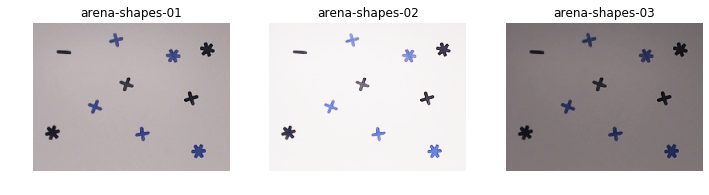

In [10]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color
Add your implementation and discussion

In [ ]:
# https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_label.html --> look it! 
# import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches

# from skimage import data
# from skimage.filters import threshold_otsu
# from skimage.segmentation import clear_border
# from skimage.measure import label, regionprops
# from skimage.morphology import closing, square
# from skimage.color import label2rgb


# image = data.coins()[50:-50, 50:-50]

# # apply threshold
# thresh = threshold_otsu(image)
# bw = closing(image > thresh, square(3))

# # remove artifacts connected to image border
# cleared = clear_border(bw)

# # label image regions
# label_image = label(cleared)
# image_label_overlay = label2rgb(label_image, image=image)

# fig, ax = plt.subplots(figsize=(10, 6))
# ax.imshow(image_label_overlay)

# for region in regionprops(label_image):
#     # take regions with large enough areas
#     if region.area >= 100:
#         # draw rectangle around segmented coins
#         minr, minc, maxr, maxc = region.bbox
#         rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
#                                   fill=False, edgecolor='red', linewidth=2)
#         ax.add_patch(rect)

# ax.set_axis_off()
# plt.tight_layout()
# plt.show()

### 2.3 Total area (in pixels) of each color
Add your implementation and discussion